https://github.com/partytax/ncei-api-guide

In [65]:
import pandas as pd
import xarray as xr
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This builds a file list of ERA5 monthly mean SST files from 1979-2021 (files are 
# for every year but contain monthly means)
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# Pandas fuction that creates an array of date time objects with an annual frequency
# during the period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # Builds complete file name and appends it to a list of files that need to
    # be downloaded
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)


In [3]:
file_list

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1980/e5.moda.an.sfc.128_034_sstk.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1982/e5.moda.an.sfc.128_034_sstk.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1983/e5.moda.an.sfc.128_034_sstk.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1984/e5.moda.an.sfc.128_034_sstk.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1985/e5.moda.an.sfc.128_034_sstk.ll025sc.1985010100_1985120100.nc',
 'https://rda.ucar.edu/thre

In [4]:
pacific_north_lat = 65.0
pacific_south_lat = -65.0
pacific_east_lon = 120.0
pacific_west_lon = 300.0

ds_sst = xr.open_mfdataset(file_list, parallel=True, chunks={'time': '50MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))

# # Extract the long term mean over the 1981-2010 period.
# ds['SSTK'].sel(latitude=slice(5,-5),longitude=slice(360-170,360-120)).mean(dim=['latitude','longitude'])
# mean_1981_2010 = ds_sub.sel(time=slice('1981-1-1','2010-12-31')).mean()

# mean_1981_2010.compute()

In [5]:
ds_sst

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK       (time, latitude, longitude) float32 dask.array<chunksize=(12, 521, 721), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [6]:
ds_sst.SSTK

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes:
    long_name:                     Sea surface temperature
    short_name:                    sstk
    units:                         K
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               34
    minimum_value:                 269.3069
    maximum_value:                 306.40942
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface anal...
    number_of_significant_digits:  7
    _ChunkSizes:                   [  3 389 776]

In [76]:
# Getting the file that we want to mask our SST data with, selecting out the Pacific 
# domain we want
land_sea_mask = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',
                      engine='netcdf4')
pacific_domain_lsm = land_sea_mask['LSM'].sel(latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))

In [77]:
pacific_domain_lsm


<xarray.DataArray 'LSM' (time: 1, latitude: 521, longitude: 721)>
[375641 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01
Attributes:
    long_name:                     Land-sea mask
    short_name:                    lsm
    units:                         (0-1)
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               172
    minimum_value:                 0.0
    maximum_value:                 1.0
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.0
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.0/
    rda_dataset_doi:               DOI: 10.5065/BH6N-5N20
    rda_dataset_group:             ERA5 atmospheric invariant fields [netCDF4]
    number_of_significant_digits:  7
    _ChunkSizes:                   [   1  721 1440]

In [78]:
# Dropping the time dimension from the LSM datarray, adding a new time dimension
# to it so the LSM dataarray is the same size as the SST dataarray, and masking
# the SST dataarray where there is land
lsm_dropped_time = pacific_domain_lsm.squeeze('time')
sst_times = pd.date_range(start='1979-01-01',end='2021-12-31', freq='MS')
lsm_all_times = lsm_dropped_time.expand_dims(dim={"time": sst_times})
lsm_all_times
masked_sample = np.ma.masked_where(lsm_all_times == 1, ds_sst.SSTK)

<xarray.DataArray 'LSM' (time: 516, latitude: 521, longitude: 721)>
array([[[0.9839221 , 0.9853388 , 0.9865974 , ..., 0.        ,
         0.        , 0.        ],
        [0.9820355 , 0.97647035, 0.971714  , ..., 0.        ,
         0.        , 0.        ],
        [0.9920217 , 0.9839088 , 0.9757792 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.9996216 ,
         0.9997698 , 0.9979298 ],
        [0.        , 0.        , 0.        , ..., 0.98418033,
         0.9213381 , 0.85825956],
        [0.        , 0.        , 0.        , ..., 0.99651325,
         0.990252  , 0.9545696 ]],

       [[0.9839221 , 0.9853388 , 0.9865974 , ..., 0.        ,
         0.        , 0.        ],
        [0.9820355 , 0.97647035, 0.971714  , ..., 0.        ,
         0.        , 0.        ],
        [0.9920217 , 0.9839088 , 0.9757792 , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 0.9996216 ,
         0.9997698 , 0.9979298 ],
        [0.        , 0.        , 0.        , ..., 0.98418033,
         0.9213381 , 0.85825956],
        [0.        , 0.        , 0.        , ..., 0.99651325,
         0.990252  , 0.9545696 ]],

       [[0.9839221 , 0.9853388 , 0.9865974 , ..., 0.        ,
         0.        , 0.        ],
        [0.9820355 , 0.97647035, 0.971714  , ..., 0.        ,
         0.        , 0.        ],
        [0.9920217 , 0.9839088 , 0.9757792 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.9996216 ,
         0.9997698 , 0.9979298 ],
        [0.        , 0.        , 0.        , ..., 0.98418033,
         0.9213381 , 0.85825956],
        [0.        , 0.        , 0.        , ..., 0.99651325,
         0.990252  , 0.9545696 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
Attributes:
    long_name:                     Land-sea mask
    short_name:                    lsm
    units:                         (0-1)
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               172
    minimum_value:                 0.0
    maximum_value:                 1.0
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.0
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.0/
    rda_dataset_doi:               DOI: 10.5065/BH6N-5N20
    rda_dataset_group:             ERA5 atmospheric invariant fields [netCDF4]
    number_of_significant_digits:  7
    _ChunkSizes:                   [   1  721 1440]

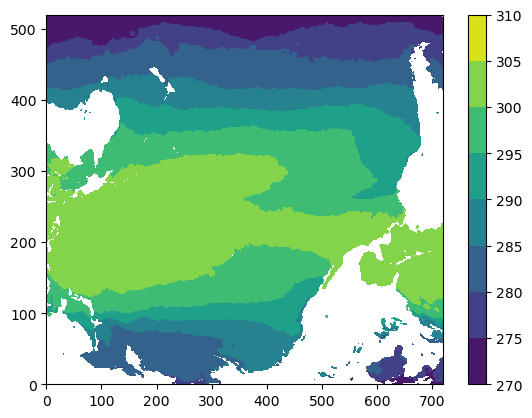

In [75]:
plt.contourf(masked_sample[8,:,:])
plt.colorbar()

In [9]:
# Computing the monthly mean ssts at every latitude and longitude box
monthly_mean_sst = ds_sst.SSTK.groupby('time.month').mean()


In [16]:
# Computes the monthly mean SST anomalies at each latitude and longitude box for 
# each year
monthly_mean_sst_ano = ds_sst.SSTK.groupby('time.month') - ds_sst.SSTK.groupby('time.month').mean(dim='time')

In [15]:
#https://foundations.projectpythia.org/core/xarray/computation-masking.html
monthly_mean_sst_ano

,Array,Chunk
Bytes,8.66 GiB,17.20 MiB
Shape,"(516, 521, 721, 12)","(12, 521, 721, 1)"
Count,2022 Tasks,516 Chunks
Type,float32,numpy.ndarray


/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


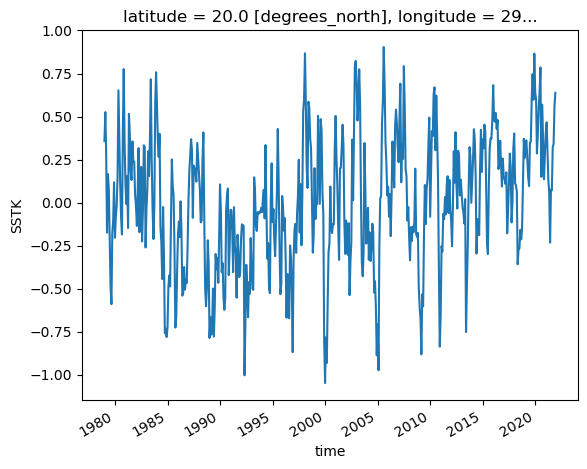

In [13]:
monthly_mean_sst_ano.sel(longitude=290, latitude=20, method='nearest').plot()